# <center> R1.04 Méthodes d'optimisation <br> TP3a - Interpolation polynomiale : Introduction </center>
<center> 2023/2024 - Tom Ferragut, Thibault Godin & Lucie Naert </center>
<center> IUT de Vannes, BUT Informatique </center>

Le but de ce TP est d'apprehénder le concept d'interpolation polynomiale.  
Le TP suivant sera consacré à une application, le _partage de secret_



In [7]:
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D 


# Affichage graphique

# %matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalisation

%matplotlib inline

names_col = list(mcolors.XKCD_COLORS)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


L'idée de base derière l'interpolation est la suivante :  
on observe $n$ points $(x_1,y_1), ..., (x_n,y_n)$ de $\mathbb{R}^2$ ;  
on suppose que ces points représentent les observation d'une fonction (inconnue) $f : \mathbb{R} \to \mathbb{R}$  

On souhaite approcher $f$ par un polynôme de degré $n-1$.  
Ce degré est le plus bas possible, en effet on a  

<div class="alert alert-block alert-info"><b>Théorème</b>

Soient $n$ points de points de $\mathbb{R}^2$ $(x_1,y_1), ..., (x_n,y_n)$  
Alors il existe un unique polynôme $P_{(x_1,y_1), ..., (x_n,y_n)}$ de degrés $n-1$ tel que $P_{(x_1,y_1), ..., (x_n,y_n)}(x_i) = y_i$ pour tout $0 \le i\le n$  

</div>

Ce théorème est la généralisation du principe que vous connaissez depuis le collège : il existe une unique droite passant par 2 points donnés.  
Dans toute la suite du TP on considère que les points $(x_1,y_1), ..., (x_n,y_n)$ sont fixés


[0, 2, 3, 4, 4.5] [  6.           1.92506768 -14.88453084 -30.68773248 -13.97523315]


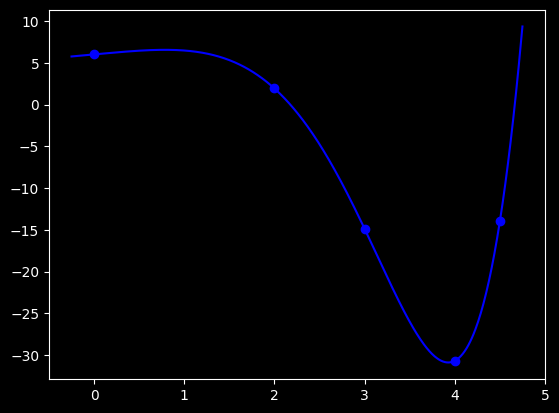

In [8]:
def f(x):
    return np.exp(x) * np.cos(x) + 5


# Données
X = [0, 2, 3, 4, 4.5]
Y = f(X)

print(X, Y)

# tracé
xcont = np.linspace(-.25, 4.75, 500)
ycont = f(xcont)
plt.plot(xcont, ycont, color = 'blue')
plt.scatter(X, Y, color = 'blue')


## Polynomes de Lagrange

Posons  
$l_i(x) = y_i \times \prod_{j=0, j\neq i}^n\frac{x-x_j}{x_i-x_j} = y_i \times \frac{x-x_0}{x_i-x_0} \cdots \frac{x-x_{i-1}}{x_i-x_{i-1}} ~ \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdots \frac{x-x_n}{x_i-x_n} $  
le $i$ème  polynôme de Lagrange et  
$L=\sum_i l_i(x) = l_1(x) + l_2(x) + \cdots + l_n(x)$  
  
**question 1**  
Calculer $l_1(x_1)$ et $l_1(x_2)$. Généraliser à $l_i(x_j)$


Réponse :  
Pour les polynômes de Lagrange, on sait que :  
$$ l_i(x) = y_i \times \prod_{\substack{j=0 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j} $$  
  
En évaluant $ l_i(x_j) $, on remarque que :
- Si $ i = j $, alors tous les termes de la forme $ \frac{x_i - x_j}{x_i - x_j} $ sont égaux à 1.
- Si $ i \neq j $, alors il existe un terme $ \frac{x_j - x_j}{x_i - x_j} $ qui est nul, rendant $ l_i(x_j) = 0 $.

En général, $ l_i(x_j) = \delta_{ij} y_i $, où $ \delta_{ij} $ est le symbole de Kronecker.


**question 2**
1. Définir une fonction `pol_li(varX,i,X,Y)` qui calcule $l_i(varX)$
1. Définir une fonction `pol_Lagrange(varX,X,Y)` qui calcule $L(varX)$

In [5]:
def pol_li(varX, i, X, Y):
    li = Y[i]
    for j in range(len(X)):
        if j != i:
            li *= (varX - X[j]) / (X[i] - X[j])
    return li


try:
    assert pol_li(X[0], 0, X, Y) == 6
    assert pol_li(X[0], 1, X, Y) == 0
    print("pol_li : OK")
except:
    print("pol_li : ERREUR")


def pol_Lagrange(varX, X, Y):
    L = 0
    for i in range(len(X)):
        L += pol_li(varX, i, X, Y)
    return L


# Pour tester pol_Lagrange, voir le tracé ci-dessous.


pol_li : OK


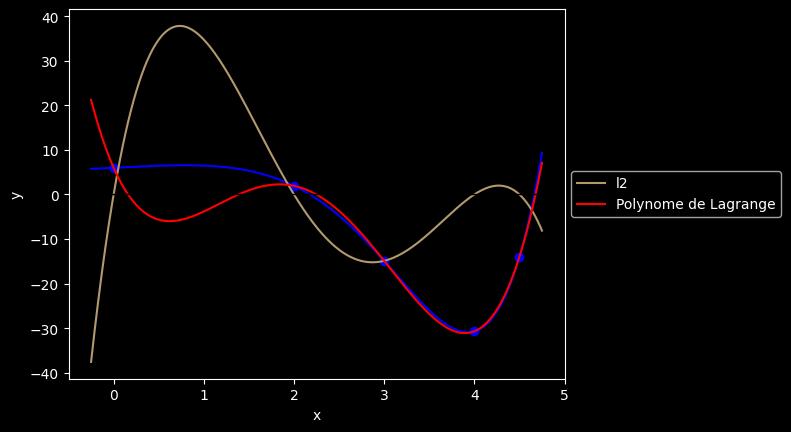

In [13]:
# tracé
plt.plot(xcont, ycont, color = 'blue')
plt.scatter(X, Y, color = 'blue')
n = len(X)


"""
for i in range(n):
    legend = "l" + str(i)
    plt.plot(xcont, pol_li(xcont, i, X, Y), label = legend, color = names_col[i])
"""


i = 2
legend = "l" + str(i)
plt.plot(xcont, pol_li(xcont, i, X, Y), label = legend,color = names_col[i])    
plt.plot(xcont, pol_Lagrange(xcont, X, Y), label = "Polynome de Lagrange", color = 'red')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y = 0, color = 'k', linewidth = 1)
plt.show()


## Algorithme de Newton


La fonction retournant le polynôme de Lagrange que nous venons d'implémenter possède un défaut : si on rajoute un point à nos données, on doit tout recalculer. Si on a de nombreuses données évoluant au cours du temps, c'est un problème  
On va donc constuire ce polynôme d'une autre façon, recursivement à l'aide des différences divisées.  
Le polynôme d'interpolation de Newton $N(x)$  
associé à $k$ points $(x_1, y_1),\ldots,(x_k, y_k)$ est défini par :  
$$N(x)=[y_1]+[y_1,y_2]n_1(x)+\ldots+[y_1,\ldots,y_k]n_{k-1}(x)$$  
Avec $n_j(x)$ le $j$-ème polynôme de Newton : $n_j(x)=\prod_{1\le i<j}(x-x_i)$  
et $[y_1,...,y_j]$ les différences divisées, définies récursivement par  
$\begin{cases}
[y_{\alpha}] &= y_{\alpha} \\
[y_{\alpha},\ldots,y_{\alpha+j}] &= \frac{[y_{\alpha+1},\ldots y_{\alpha+j}] - [y_{\alpha},\ldots y_{\alpha+j-1}]}{x_{\alpha+j}-x_{\alpha}}
\end{cases}$

**question 3**
1. Implémenter la fonction `pol_ni(varX,i,X,Y)` donnant le $i$-ème polynôme de Newton $n_i(varX)$.
2. Implémenter la fonction `diffdiv(X,Y,i)` donnant la différence divisée $[y_1,...,y_{1+i}]$


In [14]:
def pol_ni(varX, i, X):
    result = 1
    for j in range(i):
        result *= (varX - X[j])
    return result


def diffdiv(X, Y, i):
    if i == 0:
        return Y[0]
    elif i == 1:
        return (Y[1] - Y[0]) / (X[1] - X[0])
    else:
        num = diffdiv(X[1:], Y[1:], i - 1) - diffdiv(X[:-1], Y[:-1], i - 1)
        den = X[i] - X[0]
        return num / den


print(X, Y)
a=(Y[1] - Y[0]) / (X[1] - X[0])
b=(Y[2] - Y[1]) / (X[2] - X[1])

try:
    assert diffdiv(X, Y, 1) == a
    assert diffdiv(X, Y, 2) == (b - a) / (X[2] - X[0])
    print("diffdiv : OK")
except:
    print("diffdiv : ERREUR")


[0, 2, 3, 4, 4.5] [  6.           1.92506768 -14.88453084 -30.68773248 -13.97523315]
diffdiv : OK


**question 4**
1. Ecrire une fonction `pol_Newton(varX,X,Y)` qui calcule le polynôme de Newton
2. Observer graphiquement les résultats de l'interpolation.


0.0
1.7763568394002505e-15
0.0


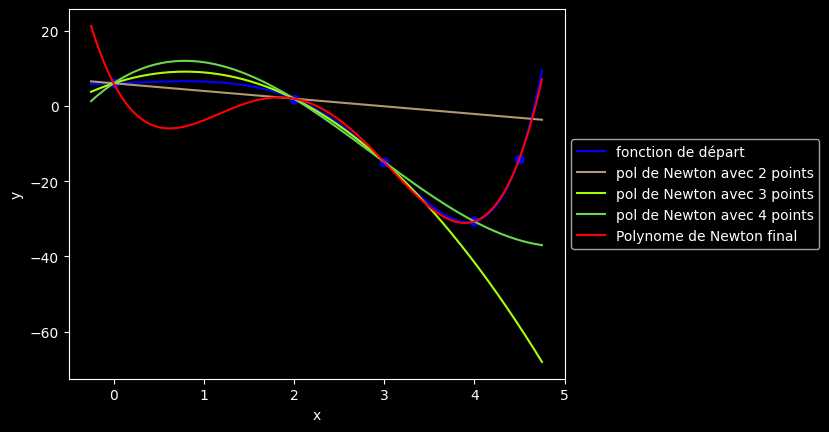

In [16]:
plt.close()


def pol_Newton(varX, X, Y):
    n = len(X)
    result = 0
    for i in range(n):
        coef = diffdiv(X[:i + 1], Y[:i + 1], i)
        result += coef * pol_ni(varX, i, X)
    return result


# Test grâce au tracé ! 
# tracé
plt.plot(xcont, ycont, label = "fonction de départ", color = 'blue')
plt.scatter(X, Y, color = 'blue')
varX = xcont
n = len(X)


for i in range(2, n):
    legend = "pol de Newton avec " + str(i) + " points"
    print(pol_Newton(X[i - 1], X[:i], Y[:i]) - Y[i - 1])
    plt.plot(xcont, pol_Newton(xcont, X[:i], Y[:i]), label = legend, color = names_col[i])


# i = 3
# legend = "n" + str(i)
# plt.plot(xcont, pol_Newton(xcont, X[:i], Y[:i]), label = legend, color = names_col[i])    
plt.plot(xcont, pol_Newton(xcont, X, Y), label = "Polynome de Newton final", color = 'red')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Interpolation et regression

Attention, l'interpolation n'est pas (forcément) un bon outil pour la prédiction pour les sciences des données :  
Premièrement l'interpolation demande de passer _exactement_ par les points  
En effet, même si l'on a un contrôle assez précis de l'erreur, donnée par les points $(x_1,y_1), ..., (x_n,y_n)$, ce qui est rarement souhaitable pour une modélisation : mieux vaut souvent une droite de regression pertinente mais ne passant par aucun point mais expliquant bien les données (coût des moindres carrés faible) plutôt qu'un polynôme de degré $n$ passant par tous les points exactement. Ce phénomène est appelé _overfitting_  en machine learning.  
Deuxièment, le polynôme interpolant n'est pas un bon outil de prédiction :

<div class="alert alert-block alert-info"><b>Proposition : erreur </b>

Si  $f$ est $n+1$ fois différentiable sur $ I = [\min(x_i),\max(x_i)]$,  alors :  
    $$\exists\xi \in I\quad f(x) - p_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^n (x-x_i)$$

</div>

il convient de remarquer que
- cette formule suppose que l'on connait bien $f$
- elle n'est valable que sur  $ I = [\min(x_i),\max(x_i)]$, on ne peut donc pas extrapoler au delà

**question 5**
illustrer la deuxième remarque avec la fonction $f : x \mapsto \sin(x)$


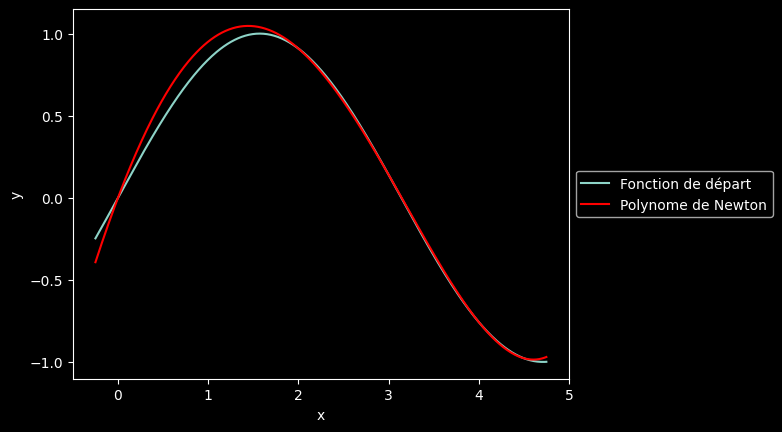

In [18]:
def f(x):
    return np.sin(x)

# Données
X = [0, 2, 3, 4, 4.5]
Y = f(X)
# tracé
xcont = np.linspace(-.25, 4.75, 500) # N'hésitez pas à changer ça !
ycont = f(xcont)
plt.plot(xcont, ycont, label = "Fonction de départ")
plt.scatter(X, Y, color = 'black')
plt.plot(xcont, pol_Newton(xcont, X, Y), label = "Polynome de Newton", color = 'red')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


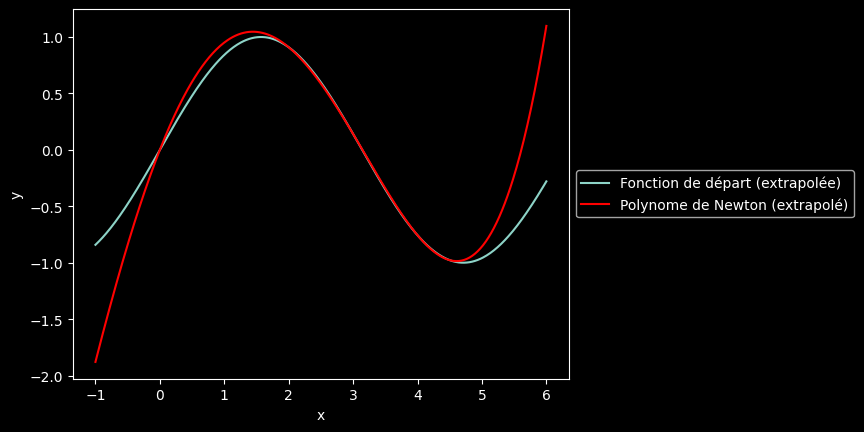

In [20]:
# Tracé avec extrapolation
xcont_extrap = np.linspace(-1, 6, 500)
ycont_extrap = f(xcont_extrap)

plt.plot(xcont_extrap, ycont_extrap, label = "Fonction de départ (extrapolée)")
plt.scatter(X, Y, color = 'black')
plt.plot(xcont_extrap, pol_Newton(xcont_extrap, X, Y), label = "Polynome de Newton (extrapolé)", color = 'red')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
